In [195]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

In [196]:
v0           = 2.0      # velocity
lambda_c = 3 #1.5
lambda_a= 0.3
lambda_a_obstacle =  0 #0.7
lambda_m = 3 # 0.5
r_n = 3
r_o = 10
eta          = 0.5      # random fluctuation in angle (in radians)
W             = 15       # width of box
H            = 10        #Height of box
R            = 1        # interaction radius
Rsq          = R**2     # square of the interaction radius
dt           = 0.2      # time step
Nt           = 80       # number of time steps
N            = 300     # number of birds
M = 10 # no of obstacles

In [197]:
def initialize_birds(N,W, H):
    '''
    Set initial positions, direction, and velocities
    '''
    # bird positions
    x = np.random.rand(N)*W
    y = np.random.rand(N)*H

    # bird velocities
    theta = 2 * np.pi * np.random.rand(N)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

In [198]:
def initialize_obstacles(M,W, H):
    x = np.random.rand(M)*W
    y = np.random.rand(M)*H

    return x,y

In [199]:
x_o, y_o = initialize_obstacles(M,W,H)

In [200]:
def dead_bird(x,y,x_o, y_o):

    k = 0
    for bird in range(N):
        croppers = (x_o-x[bird])**2+(y_o-y[bird])**2 < 0.01
        k += sum(croppers)

    return k

In [201]:
def apply_boundary_conditions(x,y,W, H):
    '''
    Apply periodic boundary conditions
    '''
    x = x % W
    y = y % H
    return x, y

In [202]:
def update_positions(x, y,xv, vy, dt, W, H):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''

    # update positions
    x += vx*dt
    y += vy*dt

    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,W,H)
    return x, y

In [203]:
def centre_of_mass(x, x_boundary, y, y_boundary, lambda_c, R):
    # define neighbours birds can see

    vx_c=np.zeros_like(x)
    vy_c=np.zeros_like(y)

    for bird in range(N):
        neighbors = (x-x[bird])**2+(y-y[bird])**2 < R**2 # find neighbours x_j within R
        boundary_neighbors = (x_boundary - x[bird])**2 + (y_boundary-y[bird])**2 < R**2


        Ni = sum(neighbors) + sum(boundary_neighbors)
        sumx= np.sum(x[neighbors]) + np.sum(x[boundary_neighbors])
        sumy= np.sum(y[neighbors]) + np.sum(y[boundary_neighbors])

        vx_c[bird] = lambda_c*(sumx/Ni-x[bird])
        vy_c[bird] = lambda_c*(sumy/Ni-y[bird])

    return vx_c, vy_c

In [204]:
def avoid_collisions_birds(x, x_boundary, y, y_boundary, lambda_a, r_n):
    # define birds within minimum distance

    vx_a=np.zeros_like(x)
    vy_a=np.zeros_like(x)
    for bird in range(N):
        neighbors = (x-x[bird])**2+(y-y[bird])**2 < r_n**2 # find neighbours x_j within r_n
        boundary_neighbors = (x_boundary - x[bird])**2 + (y_boundary - y[bird])**2 <  r_n**2


        vx_a[bird] = lambda_a*(np.sum(x[bird]-x[neighbors]) + np.sum(x[bird] - x_boundary[boundary_neighbors])) # -np.sum(x[boundary_neighbors]))
        vy_a[bird] = lambda_a*(np.sum(y[bird]-y[neighbors]) + np.sum(y[bird] - y_boundary[boundary_neighbors]))

    return vx_a, vy_a

In [205]:
def avoid_collisions_obstacle(x, y, x_o, y_o, lambda_a_obstacle, r_o):

    vx_a=np.zeros_like(x)
    vy_a=np.zeros_like(x)

    for birds in range(N):
        collisions = (x_o-x[birds])**2+(y_o-y[birds])**2 < r_o**2 # find obstacles x_j within r_o


        vx_a[birds] = lambda_a_obstacle*(np.sum(x[birds]-x_o[collisions])) # -np.sum(x_o[boundary_collision]))
        vy_a[birds] = lambda_a_obstacle*(np.sum(y[birds]-y_o[collisions])) # -np.sum(y_o[boundary_collision]))


    return vx_a, vy_a

In [206]:
def match_velocities(x, x_boundary, y, y_boundary, vx, vy, lambda_m, R):

    vx_m=np.zeros_like(x)
    vy_m=np.zeros_like(x)

    for bird in range(N):
        neighbors = (x-x[bird])**2+(y-y[bird])**2 < R**2 # find neighbours x_j within R
        boundary_neighbors = (x_boundary - x[bird])**2 + (y_boundary - y[bird])**2 < R**2


        Ni = sum(neighbors) + sum(boundary_neighbors)  # + sum(boundary_neighbors)

        sumx= np.sum(vx[neighbors]) + np.sum(vx[boundary_neighbors])
        sumy= np.sum(vy[neighbors]) + np.sum(vy[boundary_neighbors])

        vx_m[bird] = lambda_m*(sumx / Ni - vx[bird])
        vy_m[bird] = lambda_m*(sumy / Ni - vy[bird])

    return vx_m, vy_m

In [207]:
def update_velocities(vx,vy,x,y):
    '''
    Update the velocities given theta
    '''

    x_boundary = x.copy()
    x_boundary[x < W / 2] =  x[x < W / 2] + W
    x_boundary[x >= W / 2] = x[x >= W / 2] - W

    y_boundary = y.copy()
    y_boundary[y < H / 2] = y[y < H / 2] + H
    y_boundary[y >= H / 2] = y[y >= H / 2] - H

    vx_c, vy_c = centre_of_mass(x, x_boundary, y, y_boundary, lambda_c, R)
    vx_m, vy_m = match_velocities(x, x_boundary, y, y_boundary, vx, vy, lambda_m, R)
    vx_ab, vy_ab = avoid_collisions_birds(x, x_boundary, y, y_boundary, lambda_a, r_n)

    vx_ao, vy_ao = avoid_collisions_obstacle(x,y,x_o, y_o, lambda_a_obstacle, r_o)

    vx = vx + vx_c + vx_m + vx_ab + vx_ao
    vy = vy + vy_c + vy_m + vy_ab + vy_ao

    return vx, vy

In [208]:
def limit_speed(vx, vy, v0):

    vx, vy = update_velocities(vx, vy, x, y)

    vx_next = np.zeros_like(x)
    vy_next = np.zeros_like(x)

    for i in range(N):
        vx_next[i] = min(1, v0/np.sqrt(vx[i]**2+vy[i]**2))*vx[i]
        vy_next[i] = min(1, v0/np.sqrt(vx[i]**2+vy[i]**2))*vy[i]

    return vx_next, vy_next

In [209]:
def step(x,y,vx,vy,dt):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''


    x,y = update_positions(x, y, vx, vy, dt, W, H)
    vx,vy = limit_speed(vx,vy,v0)
    return x, y, vx, vy

In [210]:
def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    return q

KeyboardInterrupt: ignored

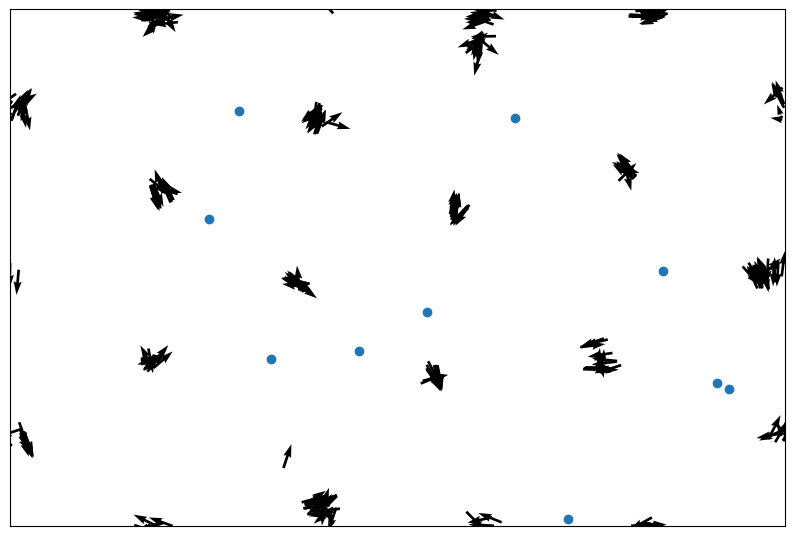

In [211]:

# set up a figure
fig, ax = plt.subplots(figsize = (10,10))

# get the initial configuration
x, y, vx, vy, theta = initialize_birds(N,W,H)

# do an initial plot and set up the axes
q = plt.quiver(x,y,vx,vy)
ax.set(xlim=(0, W), ylim=(0, H))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

k=0
plt.scatter(x_o, y_o)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    #k += dead_bird(x,y,x_o,y_o)
    x,y,vx,vy = step(x,y,vx,vy,dt)
    q = update_quiver(q,x,y,vx,vy)
    clear_output(wait=True)
    display(fig)
    plt.savefig('flock.pdf')

In [ ]:
print('The number of birds who died (got too close to the obstacles) is '+str(k))